# Imports

In [11]:
import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline

# Functions

In [9]:
def ts_matrix(df, dur):
    """Create matrix of all cameras' mean time series.
    df - dataframe containing pedestrian counts.
    dur - time interval to resample (e.g., '1Min')."""
    
    ts = []
    # -- Sort time series' by mean value & return resampled time series.
    for idx, cam in enumerate(df.groupby("cam_id").mean().sort_values("count", ascending=False).index):
        print "Camera: {} ({}/{})".format(cam, idx, len(df.cam_id.unique()))
        clear_output(wait=True)
        ts.append(resample_min(df[df.cam_id == cam], cam, dur))
    return pd.concat(ts, axis=1).T

def resample_min(df, col_name, dur):
    """Calculate mean time series by time interval 'dur'.
    df - dataframe containing pedestrian counts.
    col_name - resulting column name.
    dur - time interval to resample (e.g., '1Min')."""
    
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today(), x),
                     temp["date"].dt.time)
    temp = temp.resample(dur, level=0).mean()[["count"]]
    temp.columns = [str(col_name)]
    return temp

# Load Data

In [3]:
counts = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str,
                        "count": int, "imtime": str}, parse_dates=["date"],
                 infer_datetime_format=True, index_col="date")
counts.head(2)

,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


In [5]:
df = counts[["cam_id", "count"]].reset_index() \
        .merge(cams[cams["people"] == 1.][["cam_id", "boro"]])
df.head(2)

,date,cam_id,count,boro
0,2017-06-27 20:09:22,368,1,Manhattan
1,2017-06-27 20:10:39,368,1,Manhattan


In [13]:
si = pd.read_csv("../data/external/si_ferry_weekday_si_departures.csv",
                 names=["AM", "PM"], header=0)
si.AM = si.AM + " AM"
si.PM = si.PM + " PM"
si = pd.DataFrame(pd.concat([si.AM, si.PM]), columns=["Time"]).reset_index(drop=True)
si["departure"] = pd.to_datetime("2017-09-08 " + si["Time"])

# Periodicity @ Camera 985

In [12]:
mh_weekday = ts_matrix(df[(df.boro == "Manhattan") &
                          (df.date.dt.weekday < 5)], "1Min")

Camera: 795 (154/155)


[('cam_id', 985), ('cctv_id', '873'), ('description', 'Water St @ Whitehall')]


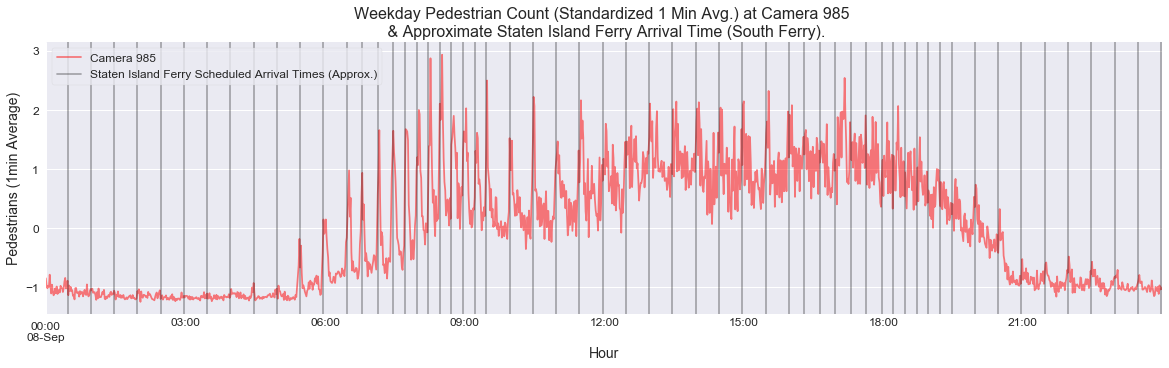

In [14]:
print zip(cams.columns[:3], cams[cams.cam_id == 985].values[0][:3])

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))

# -- Standardize mean weekday timeseries & plot.
((mh_weekday.T - mh_weekday.T.mean()) / mh_weekday.T.std())[mh_weekday.T.columns[20]].plot(c="r", alpha=0.5, ax=ax1, label="Camera 985")

# -- Plot vertical lines for each SI ferry departure time 
# -- with 28 min offset (approx. trip duration).
for dep in si.departure:
    ax1.axvline(x=dep + pd.Timedelta("28 min"), color="k", alpha=0.3, label="Staten Island Ferry Scheduled Arrival Times (Approx.)")

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], loc="upper left", fontsize=12, frameon=True)
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_xlabel("Hour", fontsize=14)
ax1.set_ylabel("Pedestrians (1min Average)", fontsize=14)
ax1.set_title("""Weekday Pedestrian Count (Standardized 1 Min Avg.) at Camera 985 \n & Approximate Staten Island Ferry Arrival Time (South Ferry).""", fontsize=16)